In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import json
import pandas as pd
import xgboost as xgb

In [4]:
with open('/home/taeun8991/descriptor_model/vectorization_1/x_vector_Td', 'r') as file:
    x_vector = json.load(file)

with open('/home/taeun8991/descriptor_model/vectorization_1/y_vector_Td', 'r') as file:
    y_vector = json.load(file)

with open('/home/taeun8991/descriptor_model/vectorization_1/refcode_list_Td', 'r') as f:
    refcode_list = json.load(f)

In [13]:
# Load the dictionaries and list from the JSON files
with open('/home/taeun8991/pmtf/decomposition_temperature/test_decomposition_temperature.json', 'r') as f:
    test_density_dict = json.load(f)


# Get the keys from the test_density_30000.json dictionary
test_keys = list(test_density_dict.keys())

# Get the indices of the keys in the refcode_list_density.json list
test_indices = [refcode_list.index(key) for key in test_keys]

X_test_before = [x_vector[i] for i in test_indices]
y_test_before = [y_vector[i] for i in test_indices]

# exclude_keys = ['QUYRAF', 'ICAWUF', 'BAVWIG', 'CABSOQ', 'UBAZOQ', 'BAVWOM', 'KOMGEZ', 'LECGOR']

train_indices = [i for i in range(len(x_vector)) if i not in test_indices] # refcode_list[i] not in exclude_keys and
X_train_before = [x_vector[i] for i in train_indices]
y_train_before = [y_vector[i] for i in train_indices]

# Filter out invalid sublists
filtered_indices_test = [
    i for i, sublist in enumerate(X_test_before) 
    if not any(
        (isinstance(value, (float, int)) and (np.isinf(value) or np.abs(value) > np.finfo(np.float32).max or np.isnan(value) or value == 'nan'))
        for value in sublist
    )
]

filtered_indices_train = [
    i for i, sublist in enumerate(X_train_before) 
    if not any(
        (isinstance(value, (float, int)) and (np.isinf(value) or np.abs(value) > np.finfo(np.float32).max or np.isnan(value) or value == 'nan'))
        for value in sublist
    )
]

X_test_after = [X_test_before[i] for i in filtered_indices_test]
y_test_after = [y_test_before[i] for i in filtered_indices_test]


X_train_after = [X_train_before[i] for i in filtered_indices_train]
y_train_after = [y_train_before[i] for i in filtered_indices_train]

# Convert filtered lists to arrays
X_trainval = np.array(X_train_after).astype(float)
y_trainval = np.array(y_train_after).astype(float)
X_test = np.array(X_test_after).astype(float)
y_test = np.array(y_test_after).astype(float)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

In [15]:
gbm_model_exp = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Train the model on the training set and evaluate on the validation set
gbm_model_exp.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=10, verbose=False)

# Evaluate on the train set
y_train_pred_exp = gbm_model_exp.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred_exp)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred_exp)
print("Train Mean Squared Error:", train_mse)
print("Train Root Mean Square Error:",train_rmse)
print("Train R-squared (R2):", train_r2)

# After hyperparameter tuning, evaluate the final model on the test set
y_test_pred_exp = gbm_model_exp.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred_exp)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred_exp)
print("Test Mean Squared Error:", test_mse)
print("Train Root Mean Square Error:",test_rmse)
print("Test R-squared (R2):", test_r2)

/home/taeun8991/anaconda3/envs/feature_extraction/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/taeun8991/anaconda3/envs/feature_extraction/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Train Mean Squared Error: 10412.9698041433
Train Root Mean Square Error: 102.04396015513755
Train R-squared (R2): 0.3999389892705124
Test Mean Squared Error: 16841.80882355861
Train Root Mean Square Error: 129.77599478932385
Test R-squared (R2): 0.09890374555347159


/home/taeun8991/anaconda3/envs/feature_extraction/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/taeun8991/anaconda3/envs/feature_extraction/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


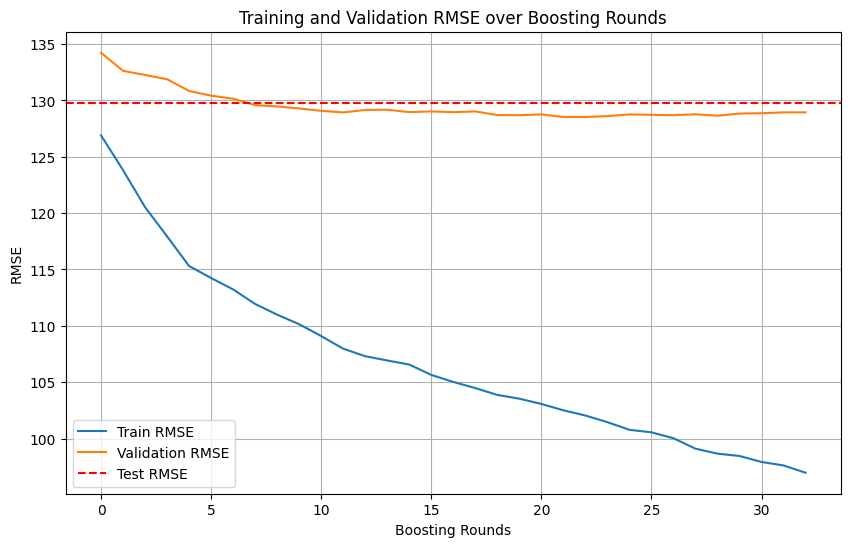

In [17]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Initialize XGBoost model
gbm_model_exp = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Train the model on the training set and evaluate on the validation set
evals_result = {}
gbm_model_exp.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse', early_stopping_rounds=10, verbose=False)

# Extract training and validation RMSE from the model's evaluation history
train_rmse = gbm_model_exp.evals_result()['validation_0']['rmse']
val_rmse = gbm_model_exp.evals_result()['validation_1']['rmse']

# Calculate RMSE on the test set
test_rmse = mean_squared_error(y_test, gbm_model_exp.predict(X_test), squared=False)

# Plot training and validation RMSE over boosting rounds
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_rmse)), train_rmse, label='Train RMSE')
plt.plot(range(len(val_rmse)), val_rmse, label='Validation RMSE')
plt.axhline(test_rmse, color='red', linestyle='--', label='Test RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()